In [5]:
# Gradio app that takes seismic waveform as input and marks 2 phases on the waveform as output.

import gradio as gr
import numpy as np
import pandas as pd
from phasehunter.data_preparation import prepare_waveform
import torch
import io

from scipy.stats import gaussian_kde
from scipy.signal import resample
from scipy.interpolate import interp1d

from bmi_topography import Topography
import earthpy.spatial as es

import obspy
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNNoDataException, FDSNTimeoutException, FDSNInternalServerException
from obspy.geodetics.base import locations2degrees
from obspy.taup import TauPyModel
from obspy.taup.helper_classes import SlownessModelError

from obspy.clients.fdsn.header import URL_MAPPINGS

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import ImageGrid

from glob import glob


def resample_waveform(waveform, original_freq, target_freq):
    """
    Resample a waveform from original frequency to target frequency using SciPy's resample function.
    
    Args:
    waveform (numpy.ndarray): The input waveform as a 1D array.
    original_freq (float): The original sampling frequency of the waveform.
    target_freq (float): The target sampling frequency of the waveform.
    
    Returns:
    resampled_waveform (numpy.ndarray): The resampled waveform as a 1D array.
    """
    # Calculate the resampling ratio
    resampling_ratio = target_freq / original_freq
    # Calculate the new length of the resampled waveform
    resampled_length = int(waveform.shape[-1] * resampling_ratio)
    # Resample the waveform using SciPy's resample function
    resampled_waveform = resample(waveform, resampled_length, axis=-1)
    
    return resampled_waveform

def sort_channels_to_ZNE(waveform, channels):
    # Input:
    # waveform: a 2D numpy array with shape (3, n), where n is the number of samples
    # channels: a list or tuple of 3 strings representing the channel order, e.g. ('N', 'Z', 'E')
    channels = list(channels)

    if len(channels) != 3 or set(channels) != {'Z', 'N', 'E'}:
        raise ValueError("Invalid channel input. It should be a permutation of 'Z', 'N', and 'E'.")

    # Find the indices of the Z, N, and E channels
    z_index = channels.index('Z')
    n_index = channels.index('N')
    e_index = channels.index('E')
    
    print(z_index, n_index, e_index)
    # Sort the channels to ZNE
    sorted_waveform = waveform[[z_index, n_index, e_index], :]
    
    return sorted_waveform

def make_prediction(waveform, sampling_rate, order):
    waveform = np.load(waveform)
    print('Loaded', waveform.shape)

    if len(waveform.shape) == 1:
        waveform = waveform.reshape(1, waveform.shape[0])

    elif waveform.shape[0] == 3:
        waveform = sort_channels_to_ZNE(waveform, order)

    if sampling_rate != 100:
        waveform = resample_waveform(waveform, sampling_rate, 100)
        print('Resampled', waveform.shape)


    orig_waveform = waveform[:, :6000].copy()
    processed_input = prepare_waveform(waveform)

    # Make prediction
    with torch.inference_mode():
        output = model(processed_input)

    p_phase = output[:, 0]
    s_phase = output[:, 1]

    return processed_input, p_phase, s_phase, orig_waveform


def mark_phases(waveform, uploaded_file, p_thres, s_thres, sampling_rate, order):

    if uploaded_file is not None:
        waveform = uploaded_file.name

    processed_input, p_phase, s_phase, orig_waveform = make_prediction(waveform, sampling_rate, order)

    # Create a plot of the waveform with the phases marked
    if sum(processed_input[0][2] == 0): #if input is 1C
        fig, ax = plt.subplots(nrows=2, figsize=(10, 2), sharex=True)

        ax[0].plot(orig_waveform[0], color='black', lw=1)
        ax[0].set_ylabel('Norm. Ampl.')

    else: #if input is 3C
        fig, ax = plt.subplots(nrows=4, figsize=(10, 6), sharex=True)
        ax[0].plot(orig_waveform[0], color='black', lw=1)
        ax[1].plot(orig_waveform[1], color='black', lw=1)
        ax[2].plot(orig_waveform[2], color='black', lw=1)

        ax[0].set_ylabel('Z')
        ax[1].set_ylabel('N')
        ax[2].set_ylabel('E')


    do_we_have_p = (p_phase.std().item()*60 < p_thres)
    if do_we_have_p:
        p_phase_plot = p_phase*processed_input.shape[-1]
        p_kde = gaussian_kde(p_phase_plot)
        p_dist_space = np.linspace( min(p_phase_plot)-10, max(p_phase_plot)+10, 500 )
        ax[-1].plot( p_dist_space, p_kde(p_dist_space), color='r')
    else:
        ax[-1].text(0.5, 0.75, 'No P phase detected', horizontalalignment='center', verticalalignment='center', transform=ax[-1].transAxes)

    do_we_have_s = (s_phase.std().item()*60 < s_thres)
    if do_we_have_s:
        s_phase_plot = s_phase*processed_input.shape[-1]
        s_kde = gaussian_kde(s_phase_plot)
        s_dist_space = np.linspace( min(s_phase_plot)-10, max(s_phase_plot)+10, 500 )
        ax[-1].plot( s_dist_space, s_kde(s_dist_space), color='b')

        for a in ax:
            a.axvline(p_phase.mean()*processed_input.shape[-1], color='r', linestyle='--', label='P', alpha=do_we_have_p)
            a.axvline(s_phase.mean()*processed_input.shape[-1], color='b', linestyle='--', label='S', alpha=do_we_have_s)
    else:
        ax[-1].text(0.5, 0.25, 'No S phase detected', horizontalalignment='center', verticalalignment='center', transform=ax[-1].transAxes)

    ax[-1].set_xlabel('Time, samples')
    ax[-1].set_ylabel('Uncert., samples')
    ax[-1].legend()

    plt.subplots_adjust(hspace=0., wspace=0.)

    # Convert the plot to an image and return it
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return image

def bin_distances(distances, bin_size=10):
    # Bin the distances into groups of `bin_size` kilometers
    binned_distances = {}
    for i, distance in enumerate(distances):
        bin_index = distance // bin_size
        if bin_index not in binned_distances:
            binned_distances[bin_index] = (distance, i)
        elif i < binned_distances[bin_index][1]:
            binned_distances[bin_index] = (distance, i)

    # Select the first distance in each bin and its index
    first_distances = []
    for bin_index in binned_distances:
        first_distance, first_distance_index = binned_distances[bin_index]
        first_distances.append(first_distance_index)
    
    return first_distances

def variance_coefficient(residuals):
    # calculate the variance of the residuals
    var = residuals.var()
    # scale the variance to a coefficient between 0 and 1
    coeff = 1 - (var / (residuals.max() - residuals.min()))
    return coeff

def predict_on_section(client_name, timestamp, eq_lat, eq_lon, radius_km, source_depth_km, velocity_model, max_waveforms, conf_thres_P, conf_thres_S):
    distances, t0s, st_lats, st_lons, waveforms, names = [], [], [], [], [], []
    
    taup_model = TauPyModel(model=velocity_model)
    client = Client(client_name)

    window = radius_km / 111.2
    max_waveforms = int(max_waveforms)

    assert eq_lat - window > -90 and eq_lat + window < 90, "Latitude out of bounds"
    assert eq_lon - window > -180 and eq_lon + window < 180, "Longitude out of bounds"

    starttime = obspy.UTCDateTime(timestamp)
    endtime = starttime + 120

    try:
        print('Starting to download inventory')
        inv = client.get_stations(network="*", station="*", location="*", channel="*H*", 
                            starttime=starttime, endtime=endtime, 
                            minlatitude=(eq_lat-window), maxlatitude=(eq_lat+window),
                            minlongitude=(eq_lon-window), maxlongitude=(eq_lon+window), 
                            level='station')
        print('Finished downloading inventory')
        
    except (IndexError, FDSNNoDataException, FDSNTimeoutException, FDSNInternalServerException):
        fig, ax = plt.subplots()
        ax.text(0.5,0.5,'Something is wrong with the data provider, try another')
        fig.canvas.draw();
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)
        return image
    
    waveforms = []
    cached_waveforms = glob("data/cached/*.mseed")

    for network in inv:
        if network.code == 'SY':
            continue
        for station in network:
            print(f"Processing {network.code}.{station.code}...")
            distance = locations2degrees(eq_lat, eq_lon, station.latitude, station.longitude)

            arrivals = taup_model.get_travel_times(source_depth_in_km=source_depth_km, 
                                                    distance_in_degree=distance, 
                                                    phase_list=["P", "S"])

            if len(arrivals) > 0:

                starttime = obspy.UTCDateTime(timestamp) + arrivals[0].time - 15
                endtime = starttime + 60
                try:
                    filename=f'{network.code}_{station.code}_{starttime}'
                    if f"data/cached/{filename}.mseed" not in cached_waveforms:
                        print(f'Downloading waveform for {filename}')
                        waveform = client.get_waveforms(network=network.code, station=station.code, location="*", channel="*", 
                                                    starttime=starttime, endtime=endtime)
                        waveform.write(f"data/cached/{network.code}_{station.code}_{starttime}.mseed", format="MSEED")
                        print('Finished downloading and caching waveform')
                    else:
                        print('Reading cached waveform')
                        waveform = obspy.read(f"data/cached/{network.code}_{station.code}_{starttime}.mseed")
                        

                except (IndexError, FDSNNoDataException, FDSNTimeoutException, FDSNInternalServerException):
                    print(f'Skipping {network.code}_{station.code}_{starttime}')
                    continue
            
                waveform = waveform.select(channel="H[BH][ZNE]")
                waveform = waveform.merge(fill_value=0)
                waveform = waveform[:3].sort(keys=['channel'], reverse=True)

                len_check = [len(x.data) for x in waveform]
                if len(set(len_check)) > 1:
                    continue

                if len(waveform) == 3:
                    try:
                        waveform = prepare_waveform(np.stack([x.data for x in waveform]))

                        distances.append(distance)
                        t0s.append(starttime)
                        st_lats.append(station.latitude)
                        st_lons.append(station.longitude)
                        waveforms.append(waveform)
                        names.append(f"{network.code}.{station.code}")

                        print(f"Added {network.code}.{station.code} to the list of waveforms")

                    except:
                        continue
                
    
    # If there are no waveforms, return an empty plot
    if len(waveforms) == 0:
        print('No waveforms found')
        fig, ax = plt.subplots()
        # prints "No waveforms found" on the plot aligned at center and vertically
        ax.text(0.5,0.5,'No waveforms found', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        fig.canvas.draw();
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)

        output_picks = pd.DataFrame()
        output_picks.to_csv('data/picks.csv', index=False)
        output_csv = 'data/picks.csv'
        return image, output_picks, output_csv
    

    first_distances = bin_distances(distances, bin_size=10/111.2)

    # Edge case when there are way too many waveforms to process
    selection_indexes = np.random.choice(first_distances, 
                                         np.min([len(first_distances), max_waveforms]),
                                         replace=False)

    waveforms = np.array(waveforms)[selection_indexes]
    distances = np.array(distances)[selection_indexes]
    t0s = np.array(t0s)[selection_indexes]
    st_lats = np.array(st_lats)[selection_indexes]
    st_lons = np.array(st_lons)[selection_indexes]
    names = np.array(names)[selection_indexes]

    waveforms = [torch.tensor(waveform) for waveform in waveforms]

    print('Starting to run predictions')
    with torch.no_grad():
        waveforms_torch = torch.vstack(waveforms)
        output = model(waveforms_torch)

    p_phases = output[:, 0]
    s_phases = output[:, 1]

    p_phases = p_phases.reshape(len(waveforms),-1)
    s_phases = s_phases.reshape(len(waveforms),-1)

    # Max confidence - min variance    
    p_max_confidence = p_phases.std(axis=-1).min()
    s_max_confidence = s_phases.std(axis=-1).min()

    print(f"Starting plotting {len(waveforms)} waveforms")
    fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
    
    # Plot topography
    print('Fetching topography')
    params = Topography.DEFAULT.copy()
    extra_window = 0.5
    params["south"] = np.min([st_lats.min(), eq_lat])-extra_window
    params["north"] = np.max([st_lats.max(), eq_lat])+extra_window
    params["west"] = np.min([st_lons.min(), eq_lon])-extra_window
    params["east"] = np.max([st_lons.max(), eq_lon])+extra_window

    topo_map = Topography(**params)
    topo_map.fetch()
    topo_map.load()

    print('Plotting topo')
    hillshade = es.hillshade(topo_map.da[0], altitude=10)
    
    topo_map.da.plot(ax = ax[1], cmap='Greys', add_colorbar=False, add_labels=False)
    topo_map.da.plot(ax = ax[2], cmap='Greys', add_colorbar=False, add_labels=False)
    ax[1].imshow(hillshade, cmap="Greys", alpha=0.5)

    output_picks = pd.DataFrame({'station_name' : [], 
                                'st_lat' : [], 'st_lon' : [],
                                 'starttime' : [], 
                                 'p_phase, s' : [], 'p_uncertainty, s' : [], 
                                 's_phase, s' : [], 's_uncertainty, s' : [],
                                 'velocity_p, km/s' : [], 'velocity_s, km/s' : []})
                        
    for i in range(len(waveforms)):
        print(f"Plotting waveform {i+1}/{len(waveforms)}")
        current_P = p_phases[i]
        current_S = s_phases[i]
        
        x = [t0s[i] + pd.Timedelta(seconds=k/100) for k in np.linspace(0,6000,6000)]
        x = mdates.date2num(x)

        # Normalize confidence for the plot
        p_conf = 1/(current_P.std()/p_max_confidence).item()
        s_conf = 1/(current_S.std()/s_max_confidence).item()

        delta_t = t0s[i].timestamp - obspy.UTCDateTime(timestamp).timestamp

        ax[0].plot(x, waveforms[i][0, 0]*10+distances[i]*111.2, color='black', alpha=0.5, lw=1)

        if (current_P.std().item()*60 < conf_thres_P) or (current_S.std().item()*60 < conf_thres_S):
            ax[0].scatter(x[int(current_P.mean()*waveforms[i][0].shape[-1])], waveforms[i][0, 0].mean()+distances[i]*111.2, color='r', alpha=p_conf, marker='|')
            ax[0].scatter(x[int(current_S.mean()*waveforms[i][0].shape[-1])], waveforms[i][0, 0].mean()+distances[i]*111.2, color='b', alpha=s_conf, marker='|')
        
            velocity_p = (distances[i]*111.2)/(delta_t+current_P.mean()*60).item()
            velocity_s = (distances[i]*111.2)/(delta_t+current_S.mean()*60).item()

            # Generate an array from st_lat to eq_lat and from st_lon to eq_lon
            x = np.linspace(st_lons[i], eq_lon, 50)
            y = np.linspace(st_lats[i], eq_lat, 50)
            
            # Plot the array
            ax[1].scatter(x, y, c=np.zeros_like(x)+velocity_p, alpha=0.1, vmin=0, vmax=8)
            ax[2].scatter(x, y, c=np.zeros_like(x)+velocity_s, alpha=0.1, vmin=0, vmax=8)

        else:
            velocity_p = np.nan
            velocity_s = np.nan
        
        ax[0].set_ylabel('Z')
        print(f"Station {st_lats[i]}, {st_lons[i]} has P velocity {velocity_p} and S velocity {velocity_s}")

        output_picks = output_picks.append(pd.DataFrame({'station_name': [names[i]], 
                                                        'st_lat' : [st_lats[i]], 'st_lon' : [st_lons[i]],
                                                        'starttime' : [str(t0s[i])], 
                                                        'p_phase, s' : [(delta_t+current_P.mean()*60).item()], 'p_uncertainty, s' : [current_P.std().item()*60], 
                                                        's_phase, s' : [(delta_t+current_S.mean()*60).item()], 's_uncertainty, s' : [current_S.std().item()*60],
                                                        'velocity_p, km/s' : [velocity_p], 'velocity_s, km/s' : [velocity_s]}))
        
        
    # Add legend
    ax[0].scatter(None, None, color='r', marker='|', label='P')
    ax[0].scatter(None, None, color='b', marker='|', label='S')
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax[0].xaxis.set_major_locator(mdates.SecondLocator(interval=20))
    ax[0].legend()

    print('Plotting stations')
    for i in range(1,3):
        ax[i].scatter(st_lons, st_lats, color='b', label='Stations')
        ax[i].scatter(eq_lon, eq_lat, color='r', marker='*', label='Earthquake')
        ax[i].set_aspect('equal')
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 50)

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
    
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(ax[2].scatter(None, None, c=velocity_p, alpha=0.5, vmin=0, vmax=8), cax=cb_ax)

    cbar.set_label('Velocity (km/s)')
    ax[1].set_title('P Velocity')
    ax[2].set_title('S Velocity')

    for a in ax:
        a.tick_params(axis='both', which='major', labelsize=8)
        
    plt.subplots_adjust(hspace=0., wspace=0.5)
    fig.canvas.draw();
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    output_csv = f'data/velocity/{eq_lat}_{eq_lon}_{source_depth_km}_{timestamp}_{len(waveforms)}.csv'
    output_picks.to_csv(output_csv, index=False)
    
    return image, output_picks, output_csv

import numpy as np
from matplotlib import colors, cm
from scipy.interpolate import griddata

def interpolate_vel_model(velocity_model, initial_velocity, lat_values, lon_values, depth_values, n_lat, n_lon, n_depth):
    # Create a mask for points with the initial velocity
    initial_velocity_mask = (velocity_model == initial_velocity)

    # Find the indices of points with non-initial velocities
    non_initial_velocity_indices = np.argwhere(~initial_velocity_mask)

    # Extract the coordinates and corresponding velocities of the known points
    known_points = np.column_stack([lat_values[non_initial_velocity_indices[:, 0]],
                                    lon_values[non_initial_velocity_indices[:, 1]],
                                    depth_values[non_initial_velocity_indices[:, 2]]])
    
    # Find the maximum depth in the known_points
    max_known_depth = np.max(known_points[:, 2])

    known_velocities = velocity_model[~initial_velocity_mask]

    # Create a grid of points for the entire volume
    grid_points = np.array(np.meshgrid(lat_values, lon_values, depth_values, indexing='ij')).reshape(3, -1).T

    # Create a mask for grid points that are deeper than the maximum known depth
    depth_mask = grid_points[:, 2] <= max_known_depth

    # Interpolate the velocities at the grid points
    interpolated_velocities = griddata(known_points, known_velocities, grid_points[depth_mask], method='linear')

    # Fill nan values with the nearest known velocities
    interpolated_velocities_filled = griddata(known_points, known_velocities, grid_points[depth_mask], method='nearest')
    interpolated_velocities[np.isnan(interpolated_velocities)] = interpolated_velocities_filled[np.isnan(interpolated_velocities)]

    # Initialize an array with the same length as grid_points and fill it with nan values
    interpolated_velocities_with_depth_limit = np.full(grid_points.shape[0], np.nan)

    # Update the array with the interpolated velocities for the masked grid points
    interpolated_velocities_with_depth_limit[depth_mask] = interpolated_velocities

    # Reshape the interpolated velocities to match the shape of the velocity_model
    interpolated_velocity_model = interpolated_velocities_with_depth_limit.reshape(n_lat, n_lon, n_depth)

    return interpolated_velocity_model


# Function to find the closest index for a given value in an array
def find_closest_index(array, value):
    return np.argmin(np.abs(array - value))

def compute_velocity_model(azimuth, elevation, interpolate, n_lat, n_lon, n_depth):
    filename = list(output_csv.temp_files)[0]
    
    df = pd.read_csv(filename)
    filename = filename.split('/')[-1]
    
    # Current EQ location
    eq_lat = float(filename.split("_")[0])
    eq_lon = float(filename.split("_")[1])
    eq_depth = float(filename.split("_")[2])

    # Define the region of interest (latitude, longitude, and depth ranges)
    lat_range = (np.min([df.st_lat.min(), eq_lat]), np.max([df.st_lat.max(), eq_lat]))
    lon_range = (np.min([df.st_lon.min(), eq_lon]),  np.max([df.st_lon.max(), eq_lon]))
    depth_range = (0, 50)

    # Define the number of nodes in each dimension
    num_points = 100

    taup_model = TauPyModel(model='1066a')

    # Create the grid
    lat_values = np.linspace(lat_range[0], lat_range[1], n_lat)
    lon_values = np.linspace(lon_range[0], lon_range[1], n_lon)
    depth_values = np.linspace(depth_range[0], depth_range[1], n_depth)

    # Initialize the velocity model with constant values
    initial_velocity = 0  # km/s, this can be P-wave or S-wave velocity
    velocity_model = np.full((n_lat, n_lon, n_depth), initial_velocity, dtype=float)

    # Loop through the stations and update the velocity model
    for i in range(len(df)):
        if ~np.isnan(df['velocity_p, km/s'].iloc[i]):

                ray_path = taup_model.get_ray_paths_geo(source_depth_in_km=eq_depth,
                                        source_latitude_in_deg=eq_lat,
                                        source_longitude_in_deg=eq_lon,
                                        receiver_latitude_in_deg=df.st_lat.iloc[i],
                                        receiver_longitude_in_deg=df.st_lon.iloc[i],
                                        phase_list=['P', 'S'])

                # Create the interpolator objects for latitude, longitude, and depth
                interp_latitude = interp1d(np.linspace(0, ray_path[0].path['lat'].max(), len(ray_path[0].path['lat'])), ray_path[0].path['lat'])
                interp_longitude = interp1d(np.linspace(0, ray_path[0].path['lon'].max(), len(ray_path[0].path['lon'])), ray_path[0].path['lon'])
                interp_depth = interp1d(np.linspace(0, ray_path[0].path['depth'].max(), len(ray_path[0].path['depth'])), ray_path[0].path['depth'])

                # Resample the ray path to N points
                lat_values_interp = interp_latitude(np.linspace(0, ray_path[0].path['lat'].max(), num_points))
                lon_values_interp = interp_longitude(np.linspace(0, ray_path[0].path['lon'].max(), num_points))
                depth_values_interp = interp_depth(np.linspace(0, ray_path[0].path['depth'].max(), num_points))

                # Loop through the interpolated coordinates and update the grid cells with the average P-wave velocity
                for lat, lon, depth in zip(lat_values_interp, lon_values_interp, depth_values_interp):
                    lat_index = find_closest_index(lat_values, lat)
                    lon_index = find_closest_index(lon_values, lon)
                    depth_index = find_closest_index(depth_values, depth)
                    
                    if velocity_model[lat_index, lon_index, depth_index] == initial_velocity:
                        velocity_model[lat_index, lon_index, depth_index] = df['velocity_p, km/s'].iloc[i]
                    else:
                        velocity_model[lat_index, lon_index, depth_index] = (velocity_model[lat_index, lon_index, depth_index] +
                                                                            df['velocity_p, km/s'].iloc[i]) / 2

    # Create the figure and axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Set the plot limits
    ax.set_xlim3d(lat_range[0], lat_range[1])
    ax.set_ylim3d(lon_range[0], lon_range[1])
    ax.set_zlim3d(depth_range[1], depth_range[0])

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Depth (km)')
    ax.set_title('Velocity Model')
    
    # Create the meshgrid
    x, y, z = np.meshgrid(
        np.linspace(lat_range[0], lat_range[1], velocity_model.shape[0]+1),
        np.linspace(lon_range[0], lon_range[1], velocity_model.shape[1]+1),
        np.linspace(depth_range[0], depth_range[1], velocity_model.shape[2]+1),
        indexing='ij'
    )

    # Create the color array
    norm = plt.Normalize(vmin=2, vmax=8)
    colors_vel = plt.cm.plasma(norm(velocity_model)) 
    
    # Plot the voxels
    if interpolate:
        interpolated_velocity_model = interpolate_vel_model(velocity_model, initial_velocity, lat_values, lon_values, depth_values, n_lat, n_lon, n_depth)
        colors_interp = plt.cm.plasma(norm(interpolated_velocity_model))
        ax.voxels(x, y, z, interpolated_velocity_model > 0, facecolors=colors_interp, alpha=0.5, edgecolor='k')
    
    ax.voxels(x, y, z, velocity_model > 0, facecolors=colors_vel, alpha=1, edgecolor='black')

    # Set the view angle
    ax.view_init(elev=elevation, azim=azimuth)

    m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)

    # Show the plot
    fig.canvas.draw();
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    return image

# model = torch.jit.load("model.pt")
model = torch.jit.load("model.pt")

model.eval()

with gr.Blocks() as demo:
    gr.HTML("""
<div style="padding: 20px; border-radius: 10px;">
    <h1 style="font-size: 30px; text-align: center; margin-bottom: 20px;">PhaseHunter <span style="animation: arrow-anim 10s linear infinite; display: inline-block; transform: rotate(45deg) translateX(-20px);">🏹</span>

<style>
    @keyframes arrow-anim {
        0% { transform: translateX(-20px); }
        50% { transform: translateX(20px); }
        100% { transform: translateX(-20px); }
    }
</style></h1> 
    
    <p style="font-size: 16px; margin-bottom: 20px;">Detect <span style="background-image: linear-gradient(to right, #ED213A, #93291E); 
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;">P</span> and <span style="background-image: linear-gradient(to right, #00B4DB, #0083B0); 
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;">S</span> seismic phases with <span style="background-image: linear-gradient(to right, #f12711, #f5af19); 
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;">uncertainty</span></p>
    <ul style="font-size: 16px; margin-bottom: 40px;">
        <li>Detect seismic phases by selecting a sample waveform or uploading your own waveform in <code>.npy</code> format.</li>
        <li>Select an earthquake from the global earthquake catalogue and PhaseHunter will analyze seismic stations in the given radius.</li>
        <li>Waveforms should be sampled at 100 samples/sec and have 3 (Z, N, E) or 1 (Z) channels. PhaseHunter analyzes the first 6000 samples of your file.</li>
    </ul>
    <p style="font-size: 16px; margin-bottom: 20px;">Please contact me at anovosel@stanford.edu with questions and feedback</p>
</div>
""")
    with gr.Tab("Try on a single station"):
        with gr.Row(): 
            # Define the input and output types for Gradio
            inputs = gr.Dropdown(
                ["data/sample/sample_0.npy", 
                "data/sample/sample_1.npy", 
                "data/sample/sample_2.npy"], 
                label="Sample waveform", 
                info="Select one of the samples",
                value = "data/sample/sample_0.npy"
            )
            with gr.Column(scale=1):
                P_thres_inputs = gr.Slider(minimum=0.01,
                                    maximum=1,
                                    value=0.1,
                                    label="P uncertainty threshold (s)",
                                    step=0.01,
                                    info="Acceptable uncertainty for P picks expressed in std() seconds",
                                    interactive=True,
                                    )
                
                S_thres_inputs = gr.Slider(minimum=0.01,
                                    maximum=1,
                                    value=0.2,
                                    label="S uncertainty threshold (s)",
                                    step=0.01,
                                    info="Acceptable uncertainty for S picks expressed in std() seconds",
                                    interactive=True,
                                    )
            with gr.Column(scale=1):
                upload = gr.File(label="Upload your waveform")
                with gr.Row():
                    sampling_rate_inputs = gr.Slider(minimum=10,
                            maximum=1000,
                            value=100,
                            label="Samlping rate, Hz",
                            step=10,
                            info="Sampling rate of the waveform",
                            interactive=True,
                            )
                    order_input = gr.Text(value='ZNE', 
                                        label='Channel order', 
                                        info='Order of the channels in the waveform file (e.g. ZNE)')

        button = gr.Button("Predict phases")
        outputs = gr.Image(label='Waveform with Phases Marked', type='numpy', interactive=False)
    
        button.click(mark_phases, inputs=[inputs, upload, 
                                          P_thres_inputs, S_thres_inputs,
                                          sampling_rate_inputs, order_input], 
                                          outputs=outputs)    
    with gr.Tab("Select earthquake from catalogue"):

        gr.HTML("""
        <div style="padding: 20px; border-radius: 10px; font-size: 16px;">
        <p style="font-weight: bold; font-size: 24px; margin-bottom: 20px;">Using PhaseHunter to Analyze Seismic Waveforms</p>
        <p>Select an earthquake from the global earthquake catalogue (e.g. <a href="https://earthquake.usgs.gov/earthquakes/map">USGS</a>) and the app will download the waveform from the FDSN client of your choice. The app will use a velocity model of your choice to select appropriate time windows for each station within a specified radius of the earthquake.</p>
        <p>The app will then analyze the waveforms and mark the detected phases on the waveform. Pick data for each waveform is reported in seconds from the start of the waveform.</p>
        <p>Velocities are derived from distance and travel time determined by PhaseHunter picks (<span style="font-style: italic;">v = distance/predicted_pick_time</span>). The background of the velocity plot is colored by DEM.</p>
        </div>
        """)
        with gr.Row(): 
            with gr.Column(scale=2):
                client_inputs = gr.Dropdown(
                    choices = list(URL_MAPPINGS.keys()), 
                    label="FDSN Client", 
                    info="Select one of the available FDSN clients",
                    value = "IRIS",
                    interactive=True
                )

                velocity_inputs = gr.Dropdown(
                    choices = ['1066a', '1066b', 'ak135', 
                            'ak135f', 'herrin', 'iasp91', 
                            'jb', 'prem', 'pwdk'], 
                    label="1D velocity model", 
                    info="Velocity model for station selection",
                    value = "1066a",
                    interactive=True
                )

            with gr.Column(scale=2):
                timestamp_inputs = gr.Textbox(value='2019-07-04T17:33:49-00',
                                    placeholder='YYYY-MM-DDTHH:MM:SS-TZ',
                                    label="Timestamp",
                                    info="Timestamp of the earthquake",
                                    max_lines=1,
                                    interactive=True)
                
                source_depth_inputs = gr.Number(value=10,
                    label="Source depth (km)",
                    info="Depth of the earthquake",
                    interactive=True)
                
            with gr.Column(scale=2):
                eq_lat_inputs = gr.Number(value=35.766, 
                                label="Latitude", 
                                info="Latitude of the earthquake",
                                interactive=True)
                
                eq_lon_inputs = gr.Number(value=-117.605,
                                    label="Longitude",
                                    info="Longitude of the earthquake",
                                    interactive=True)
                
            with gr.Column(scale=2):
                radius_inputs = gr.Slider(minimum=1, 
                                        maximum=200, 
                                        value=50, 
                                        label="Radius (km)", 
                                        step=10,
                                        info="""Select the radius around the earthquake to download data from.\n 
                                        Note that the larger the radius, the longer the app will take to run.""",
                                        interactive=True)
                
                max_waveforms_inputs = gr.Slider(minimum=1,
                                maximum=100,
                                value=10,
                                label="Max waveforms per section",
                                step=1,
                                info="Maximum number of waveforms to show per section\n (to avoid long prediction times)",
                                interactive=True,
                                )
            with gr.Column(scale=2):
                P_thres_inputs = gr.Slider(minimum=0.01,
                                maximum=1,
                                value=0.1,
                                label="P uncertainty threshold, s",
                                step=0.01,
                                info="Acceptable uncertainty for P picks expressed in std() seconds",
                                interactive=True,
                                )
                S_thres_inputs = gr.Slider(minimum=0.01,
                                maximum=1,
                                value=0.2,
                                label="S uncertainty threshold, s",
                                step=0.01,
                                info="Acceptable uncertainty for S picks expressed in std() seconds",
                                interactive=True,
                                )
            
        button_phases = gr.Button("Predict phases")
        output_image = gr.Image(label='Waveforms with Phases Marked', type='numpy', interactive=False)
        
        with gr.Row():
            with gr.Column(scale=2):
                azimuth_input = gr.Slider(minimum=-180, maximum=180, value=0, step=5, label="Azimuth", interactive=True)
                elevation_input = gr.Slider(minimum=-90, maximum=90, value=30, step=5, label="Elevation", interactive=True)

                with gr.Row():
                    interpolate_input = gr.Checkbox(label="Interpolate", info="Interpolate velocity model")
                    n_lat_input = gr.Slider(minimum=5, maximum=100, value=50, step=5, label="N lat", info='Number of Lat grid points', interactive=True)
                    n_lon_input = gr.Slider(minimum=5, maximum=100, value=50, step=5, label="N lon", info='Number of Lon grid points', interactive=True)
                    n_depth_input = gr.Slider(minimum=5, maximum=100, value=50, step=5, label="N depth", info='Number of Depth grid points', interactive=True)
                
                button = gr.Button("Look at 3D Velocities")
            outputs_vel_model = gr.Image(label="3D Velocity Model")

        button.click(compute_velocity_model, 
                        inputs=[azimuth_input, elevation_input, 
                                interpolate_input, n_lat_input, 
                                n_lon_input, n_depth_input], 
                        outputs=[outputs_vel_model])
        
        with gr.Row():
            output_picks = gr.Dataframe(label='Pick data', 
                                        type='pandas', 
                                        interactive=False)
            output_csv = gr.File(label="Output File", file_types=[".csv"])

        button_phases.click(predict_on_section, 
                 inputs=[client_inputs, timestamp_inputs, 
                         eq_lat_inputs, eq_lon_inputs, 
                         radius_inputs, source_depth_inputs, 
                         velocity_inputs, max_waveforms_inputs,
                         P_thres_inputs, S_thres_inputs],
                 outputs=[output_image, output_picks, output_csv])

demo.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [1]:
import obspy
from obspy.clients.fdsn import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

client = Client('IRIS')

radius_km = 150
window = radius_km / 111.2
max_waveforms = 10

starttime = obspy.UTCDateTime('2023-01-23 00:00:00.000')
endtime = starttime + 60*60*24

eq_lat = 35.6173961
eq_lon = 139.7453414

inv = client.get_stations(network="*", station="*", location="*", channel="*H*", 
                    starttime=starttime, endtime=endtime, 
                    minlatitude=(eq_lat-window), maxlatitude=(eq_lat+window),
                    minlongitude=(eq_lon-window), maxlongitude=(eq_lon+window), 
                    level='response')

waveform = client.get_waveforms(network=inv[0].code, station=inv[0][0].code, location="*", channel="*", 
                                                    starttime=starttime, endtime=endtime)

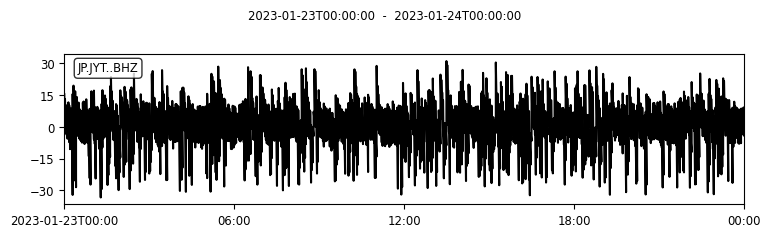

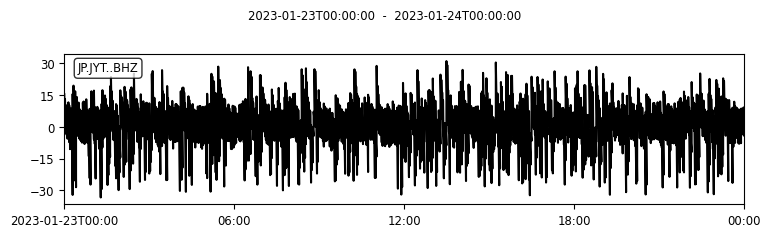

In [2]:
 waveform.copy().select(channel="*Z")[0].filter('lowpass', freq=0.1).plot()

In [2]:
db = pd.read_csv('/Users/anovosel/Downloads/trades.csv')

In [3]:
db_res = db.set_index(pd.DatetimeIndex(db['ts']))
db_res = db_res.resample('50L').interpolate()

In [25]:
from scipy import stats

length = int(1e7)
start = int(1e6)

disp = waveform.copy().select(channel="*Z")[0].remove_response(inventory=inv, output="DISP", water_level=60).data[start:length]

norm_bid = db_res['bid_price_1'][start:length]/db_res['bid_price_1'][start:length].max()
norm_disp = np.abs(disp)/np.abs(disp).max()

n = int(1e5)  # Change this value to adjust the window size
window = np.ones(n)
running_sum = np.convolve(norm_disp, window, mode='same')

fig,ax = plt.subplots(nrows=2)
ax[0].plot(norm_bid.index, running_sum, color='red')
ax[1].plot(norm_bid.index, norm_bid, color='blue')

print('Pearson correlation coefficient: ', stats.pearsonr(running_sum, norm_bid).pvalue)

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


In [6]:
import numpy as np
import matplotlib.pyplot as plt

length = int(1e7)

disp = waveform.copy().select(channel="*Z")[0].filter('lowpass', freq=0.1).remove_response(inventory=inv, output="DISP", water_level=60).data[:length]

norm_bid = db_res['bid_price_1'][:length]/db_res['bid_price_1'][:length].max()
norm_disp = np.abs(disp)/np.abs(disp).max()

n = int(1e6)  # Change this value to adjust the window size
window = np.ones(n) / n
running_mean = np.convolve(norm_disp, window, mode='same')

# Calculate gradients using numpy
grad_running_mean = np.gradient(running_mean)
grad_norm_bid = np.gradient(norm_bid)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(norm_bid.index, grad_running_mean, color='red')
ax[1].plot(norm_bid.index, grad_norm_bid, color='blue')

# Compute Pearson correlation coefficient using numpy
pearson_corr_coeff = np.corrcoef(running_mean, norm_bid)[0, 1]
print('Pearson correlation coefficient: ', pearson_corr_coeff)

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


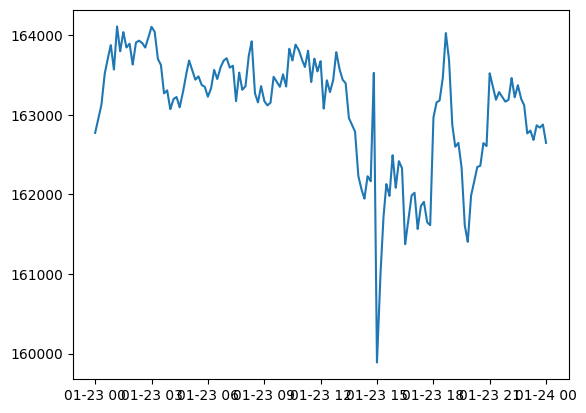

In [45]:
plt.plot(db_res['bid_price_1'])

In [27]:
import numpy as np
from scipy import stats
for column in db_res.columns:
    if column not in ['receive_ts', 'exchange_ts', 'ts', ]:
        print(column, stats.pearsonr(disp, db_res[column]).pvalue)

bid_price_1 0.012663067531922095
bid_volume_1 2.0945533214878415e-68
ask_price_1 0.012663067531922095
ask_volume_1 3.5434123510723287e-25
bid_price_2 0.012663067531922095
bid_volume_2 1.61850808697619e-120
ask_price_2 0.012663067531922095
ask_volume_2 5.8902861400057176e-136
bid_price_3 0.012663067531922095
bid_volume_3 2.8038e-319
ask_price_3 0.012663067531922095
ask_volume_3 6.910930394043699e-63
bid_price_4 0.012663067531922095
bid_volume_4 2.573769455490031e-129
ask_price_4 0.012663067531922095
ask_volume_4 3.302722834897649e-179
bid_price_5 0.012663067531922095
bid_volume_5 1.2606365805909815e-226
ask_price_5 0.012663067531922095
ask_volume_5 1.3647948258840875e-62
bid_price_6 0.012663067531922095
bid_volume_6 1.8974778193854842e-87
ask_price_6 0.012663067531922095
ask_volume_6 0.001575430227266945
bid_price_7 0.012663067531922095
bid_volume_7 4.592422309223935e-56
ask_price_7 0.012663067531922095
ask_volume_7 0.06260176464553072
bid_price_8 0.012663067531922095
bid_volume_8 3.106

In [20]:
db_res.columns

Index(['exchange_ts', 'receive_ts', 'ts', 'bid_price_1', 'bid_volume_1',
       'ask_price_1', 'ask_volume_1', 'bid_price_2', 'bid_volume_2',
       'ask_price_2', 'ask_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_3', 'ask_volume_3', 'bid_price_4', 'bid_volume_4',
       'ask_price_4', 'ask_volume_4', 'bid_price_5', 'bid_volume_5',
       'ask_price_5', 'ask_volume_5', 'bid_price_6', 'bid_volume_6',
       'ask_price_6', 'ask_volume_6', 'bid_price_7', 'bid_volume_7',
       'ask_price_7', 'ask_volume_7', 'bid_price_8', 'bid_volume_8',
       'ask_price_8', 'ask_volume_8', 'bid_price_9', 'bid_volume_9',
       'ask_price_9', 'ask_volume_9', 'bid_price_10', 'bid_volume_10',
       'ask_price_10', 'ask_volume_10'],
      dtype='object')

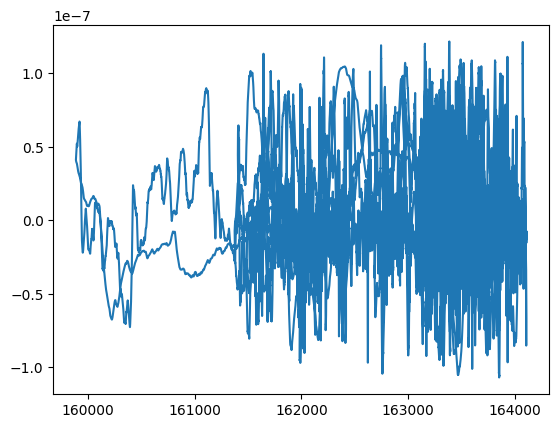

In [19]:
plt.plot(db_res['bid_price_1'], disp )

In [17]:
plt.plot()

(1728001, 1728001)

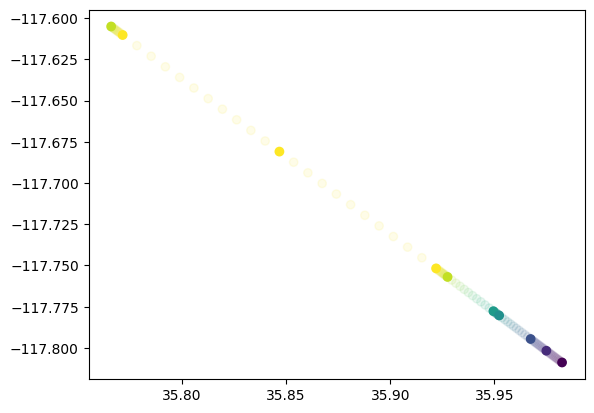

In [107]:
from scipy.interpolate import interp1d

taup_model = TauPyModel(model='1066a')

ray_path = taup_model.get_ray_paths_geo(source_depth_in_km=10,
                                    source_latitude_in_deg=35.766,
                                    source_longitude_in_deg=-117.605,
                                    receiver_latitude_in_deg=35.98249,
                                    receiver_longitude_in_deg=-117.80885,
                                    phase_list=['P', 'S'])

ray_path[0].path

# Define the number of points N
N = 100

# Create the interpolator objects for latitude, longitude, and depth
interp_latitude = interp1d(np.linspace(0, ray_path[0].path['lat'].max(), len(ray_path[0].path['lat'])), ray_path[0].path['lat'])
interp_longitude = interp1d(np.linspace(0, ray_path[0].path['lon'].max(), len(ray_path[0].path['lon'])), ray_path[0].path['lon'])
interp_depth = interp1d(np.linspace(0, ray_path[0].path['depth'].max(), len(ray_path[0].path['depth'])), ray_path[0].path['depth'])

# Resample the ray path to N points
resampled_latitude = interp_latitude(np.linspace(0, ray_path[0].path['lat'].max(), N))
resampled_longitude = interp_longitude(np.linspace(0, ray_path[0].path['lon'].max(), N))
resampled_depth = interp_depth(np.linspace(0, ray_path[0].path['depth'].max(), N))

plt.scatter(resampled_latitude, resampled_longitude, c=resampled_depth, cmap='viridis', alpha=0.1)
plt.scatter(ray_path[0].path['lat'], ray_path[0].path['lon'], c=ray_path[0].path['depth'], cmap='viridis')


In [101]:
ray_path[0].path

array([(825.43624587, 0.        , 0.        , 10.        , 35.766     , -117.605     ),
       (825.43624587, 0.26845098, 0.00012109, 11.        , 35.7715199 , -117.61017979),
       (825.43624587, 1.63173458, 0.00177268, 11.01091139, 35.84678737, -117.68090241),
       (825.43624587, 2.99501819, 0.00342427, 11.        , 35.92201332, -117.75175935),
       (825.43624587, 3.26346917, 0.00354535, 10.        , 35.92752691, -117.75695956),
       (825.43624587, 4.33607208, 0.00402859,  6.00385879, 35.94952856, -117.77772004),
       (825.43624587, 4.47129397, 0.00408945,  5.5       , 35.9522991 , -117.78033535),
       (825.43624587, 5.20940225, 0.00442139,  2.74941477, 35.96740958, -117.79460335),
       (825.43624587, 5.57829224, 0.00458712,  1.37456112, 35.97495353, -117.80172933),
       (825.43624587, 5.94707298, 0.0047527 ,  0.        , 35.98248996, -117.80884997)],
      dtype=[('p', '<f8'), ('time', '<f8'), ('dist', '<f8'), ('depth', '<f8'), ('lat', '<f8'), ('lon', '<f8')])

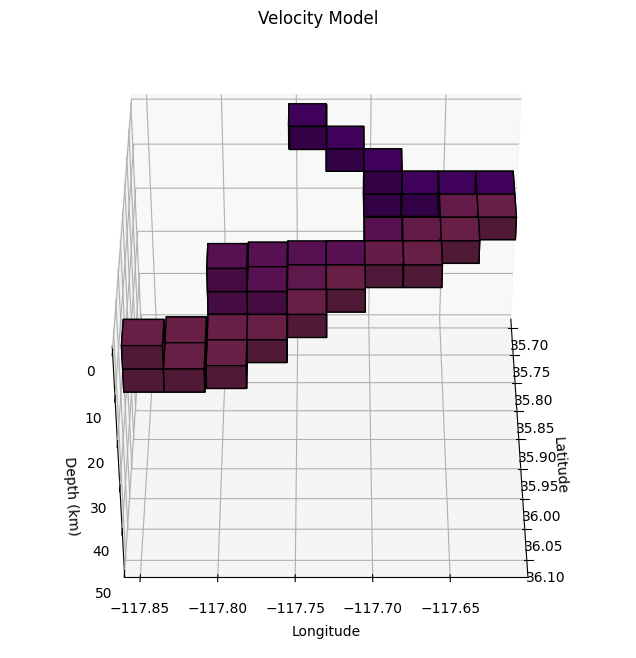

In [126]:
def compute_velocity_model(azimuth, elevation, interpolate):
    filename = list(output_csv.temp_files)[0]
    
    df = pd.read_csv(filename)
    filename = filename.split('/')[-1]
    
    # Current EQ location
    eq_lat = float(filename.split("_")[0])
    eq_lon = float(filename.split("_")[1])
    eq_depth = float(filename.split("_")[2])

    # Define the region of interest (latitude, longitude, and depth ranges)
    lat_range = (np.min([df.st_lat.min(), eq_lat]), np.max([df.st_lat.max(), eq_lat]))
    lon_range = (np.min([df.st_lon.min(), eq_lon]),  np.max([df.st_lon.max(), eq_lon]))
    depth_range = (0, 50)

    # Define the number of nodes in each dimension
    n_lat = 10
    n_lon = 10
    n_depth = 10
    num_points = 100

    taup_model = TauPyModel(model='1066a')

    # Create the grid
    lat_values = np.linspace(lat_range[0], lat_range[1], n_lat)
    lon_values = np.linspace(lon_range[0], lon_range[1], n_lon)
    depth_values = np.linspace(depth_range[0], depth_range[1], n_depth)

    # Initialize the velocity model with constant values
    initial_velocity = 0  # km/s, this can be P-wave or S-wave velocity
    velocity_model = np.full((n_lat, n_lon, n_depth), initial_velocity, dtype=float)

    # Loop through the stations and update the velocity model
    for i in range(len(df)):
        if ~np.isnan(df['velocity_p, km/s'].iloc[i]):

                ray_path = taup_model.get_ray_paths_geo(source_depth_in_km=eq_depth,
                                        source_latitude_in_deg=eq_lat,
                                        source_longitude_in_deg=eq_lon,
                                        receiver_latitude_in_deg=df.st_lat.iloc[i],
                                        receiver_longitude_in_deg=df.st_lon.iloc[i],
                                        phase_list=['P', 'S'])

                # Create the interpolator objects for latitude, longitude, and depth
                interp_latitude = interp1d(np.linspace(0, ray_path[0].path['lat'].max(), len(ray_path[0].path['lat'])), ray_path[0].path['lat'])
                interp_longitude = interp1d(np.linspace(0, ray_path[0].path['lon'].max(), len(ray_path[0].path['lon'])), ray_path[0].path['lon'])
                interp_depth = interp1d(np.linspace(0, ray_path[0].path['depth'].max(), len(ray_path[0].path['depth'])), ray_path[0].path['depth'])

                # Resample the ray path to N points
                lat_values_interp = interp_latitude(np.linspace(0, ray_path[0].path['lat'].max(), num_points))
                lon_values_interp = interp_longitude(np.linspace(0, ray_path[0].path['lon'].max(), num_points))
                depth_values_interp = interp_depth(np.linspace(0, ray_path[0].path['depth'].max(), num_points))

                # Loop through the interpolated coordinates and update the grid cells with the average P-wave velocity
                for lat, lon, depth in zip(lat_values_interp, lon_values_interp, depth_values_interp):
                    lat_index = find_closest_index(lat_values, lat)
                    lon_index = find_closest_index(lon_values, lon)
                    depth_index = find_closest_index(depth_values, depth)
                    
                    if velocity_model[lat_index, lon_index, depth_index] == initial_velocity:
                        velocity_model[lat_index, lon_index, depth_index] = df['velocity_p, km/s'].iloc[i]
                    else:
                        velocity_model[lat_index, lon_index, depth_index] = (velocity_model[lat_index, lon_index, depth_index] +
                                                                            df['velocity_p, km/s'].iloc[i]) / 2

    # Create the figure and axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Set the plot limits
    ax.set_xlim3d(lat_range[0], lat_range[1])
    ax.set_ylim3d(lon_range[0], lon_range[1])
    ax.set_zlim3d(depth_range[1], depth_range[0])

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Depth (km)')
    ax.set_title('Velocity Model')
    
    # Create the meshgrid
    x, y, z = np.meshgrid(
        np.linspace(lat_range[0], lat_range[1], velocity_model.shape[0]+1),
        np.linspace(lon_range[0], lon_range[1], velocity_model.shape[1]+1),
        np.linspace(depth_range[0], depth_range[1], velocity_model.shape[2]+1),
        indexing='ij'
    )

    # Create the color array
    norm = plt.Normalize(vmin=2, vmax=8)
    colors_vel = plt.cm.plasma(norm(velocity_model)) 
    
    # Plot the voxels
    if interpolate:
        interpolated_velocity_model = interpolate_vel_model(velocity_model, initial_velocity, lat_values, lon_values, depth_values, n_lat, n_lon, n_depth)
        colors_interp = plt.cm.plasma(norm(interpolated_velocity_model))
        ax.voxels(x, y, z, interpolated_velocity_model > 0, facecolors=colors_interp, alpha=0.5, edgecolor='k')
    
    ax.voxels(x, y, z, velocity_model > 0, facecolors=colors_vel, alpha=1, edgecolor='black')

    # Set the view angle
    ax.view_init(elev=elevation, azim=azimuth)


compute_velocity_model(0, 40, False)

In [8]:
!ls data/velocity

35.766_-117.605_10.0_2019-07-04 17:33:49_3.csv
35.766_-117.605_10.0_2019-07-04T17:33:49-00_3.csv
35.766_-117.605_2019-07-04 17:33:49_3.csv
35.766_-117.605_2019-07-04 17:33:49_9.csv
current_vel_model.csv
testt


In [13]:
!ls '/Users/anovosel/Documents/phase-hunter/data/velocity'

35.766_-117.605_10.0_2019-07-04 17:33:49_3.csv
35.766_-117.605_10.0_2019-07-04T17:33:49-00_3.csv
35.766_-117.605_2019-07-04 17:33:49_3.csv
35.766_-117.605_2019-07-04 17:33:49_9.csv
current_vel_model.csv
testt
